<a href="https://colab.research.google.com/github/StellaIbeh/sound_clustering/blob/main/Adaobi_Stella_Ibeh_sound_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **FORMATIVE ASSIGNMENT**


##Sound Clustering

In [1]:
#Make allNecessary Imports
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

##Import the zipfile

The dataset was download as a zipped file , now I tried to extract the file .

In [3]:
import zipfile
zip= zipfile.ZipFile('/content/unlabelled_sounds.zip', 'r')
zip.extractall('/content')
zip.close()


##Load the Data

In [4]:
#load the data
unlabelled_sounds = '/content/unlabelled_sounds' # Change to the extracted directory

#Load the audio
audio_files = [os.path.join(unlabelled_sounds, f) for f in os.listdir(unlabelled_sounds) if f.endswith('.wav')]

# Print first few files
print("Number of audio files:", len(audio_files))
print("First 5 files:", audio_files[:5])

Number of audio files: 3000
First 5 files: ['/content/unlabelled_sounds/1801.wav', '/content/unlabelled_sounds/1625.wav', '/content/unlabelled_sounds/2351.wav', '/content/unlabelled_sounds/1569.wav', '/content/unlabelled_sounds/1346.wav']


In [6]:
# Initialize lists to store features and filenames
features = []
filenames = []

# Loop through each audio file, load the audio, and extract Mel Spectrogram features
for file in audio_files:
    # Load audio file with its original sampling rate
    y, sr = librosa.load(file, sr=None)

    # Extract Mel Spectrogram (n_mels defines the number of Mel bands)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

    # Convert the power spectrogram (amplitude squared) to decibel (dB) units for better visualization
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Extract statistical features
    feature_vector = np.hstack((
        np.mean(mel_spec_db, axis=1),  # Mean of each frequency bin
        np.std(mel_spec_db, axis=1)    # Standard deviation of each frequency bin
    ))

    # Append the features and the base filename
    features.append(feature_vector) #Changed mel_features to feature_vector
    filenames.append(os.path.basename(file))

#The return was inside the loop causing it to terminate prematurely, hence i moved it outside the loop
#return feature_vector

# Create a DataFrame where each row corresponds to an audio file and each column is a Mel feature
features_df = pd.DataFrame(features, index=filenames)
features_df.columns = [f'Mel_{i+1}' for i in range(features_df.shape[1])]

# Display extracted features
print("Extracted Features Shape:", features_df.shape)
features_df.head()

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1965
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1858
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1900
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1704
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1932
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1710
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py

Extracted Features Shape: (3000, 256)


,Mel_1,Mel_2,Mel_3,Mel_4,Mel_5,Mel_6,Mel_7,Mel_8,Mel_9,Mel_10,...,Mel_247,Mel_248,Mel_249,Mel_250,Mel_251,Mel_252,Mel_253,Mel_254,Mel_255,Mel_256
1801.wav,-78.309860,-78.480911,-78.523071,-78.533890,-78.471977,-66.846039,-62.912590,-40.004204,-28.241196,-30.014135,...,5.233797,4.844299,4.413667,4.155063,4.814973,4.553222,5.247078,3.957393,2.808645,0.262669
1625.wav,-78.162247,-80.000000,-80.000000,-79.826889,-78.603867,-64.753700,-54.626823,-30.117188,-20.022959,-26.770124,...,10.186684,14.049411,13.559726,13.020625,14.808543,11.290902,11.880661,11.935271,11.162121,8.788675
2351.wav,-44.884655,-35.702610,-34.328899,-35.407375,-34.648064,-33.281006,-34.544891,-34.387352,-34.619125,-36.429520,...,9.892670,10.543582,10.113594,10.614638,10.714455,10.895164,11.734930,10.004243,8.618262,8.365117
1569.wav,-77.740959,-78.867844,-78.745644,-78.657036,-78.311714,-63.839153,-52.285271,-31.885052,-27.319279,-32.594337,...,8.992724,8.673435,8.932113,8.544509,7.257756,6.329917,5.151269,6.208786,6.425540,3.986496
1346.wav,-67.627289,-65.364159,-62.172081,-66.935684,-61.216873,-54.430313,-49.792419,-46.550648,-41.639324,-36.207230,...,3.529175,2.955408,5.636585,4.313334,3.476323,6.362425,7.248246,7.397096,6.610439,1.464466


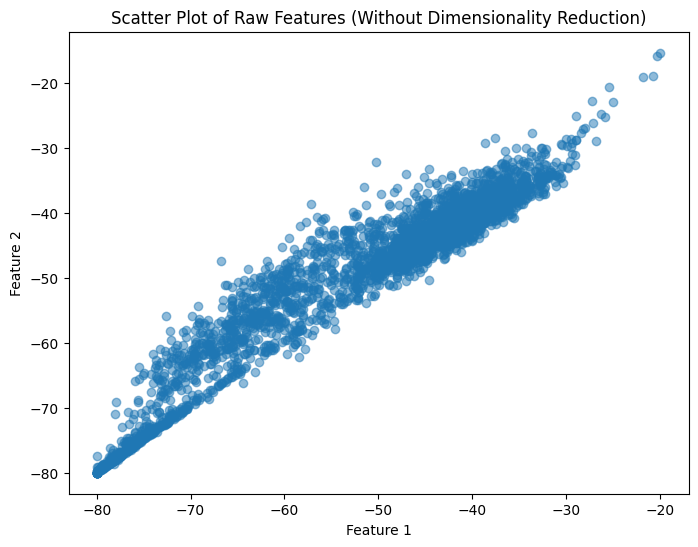

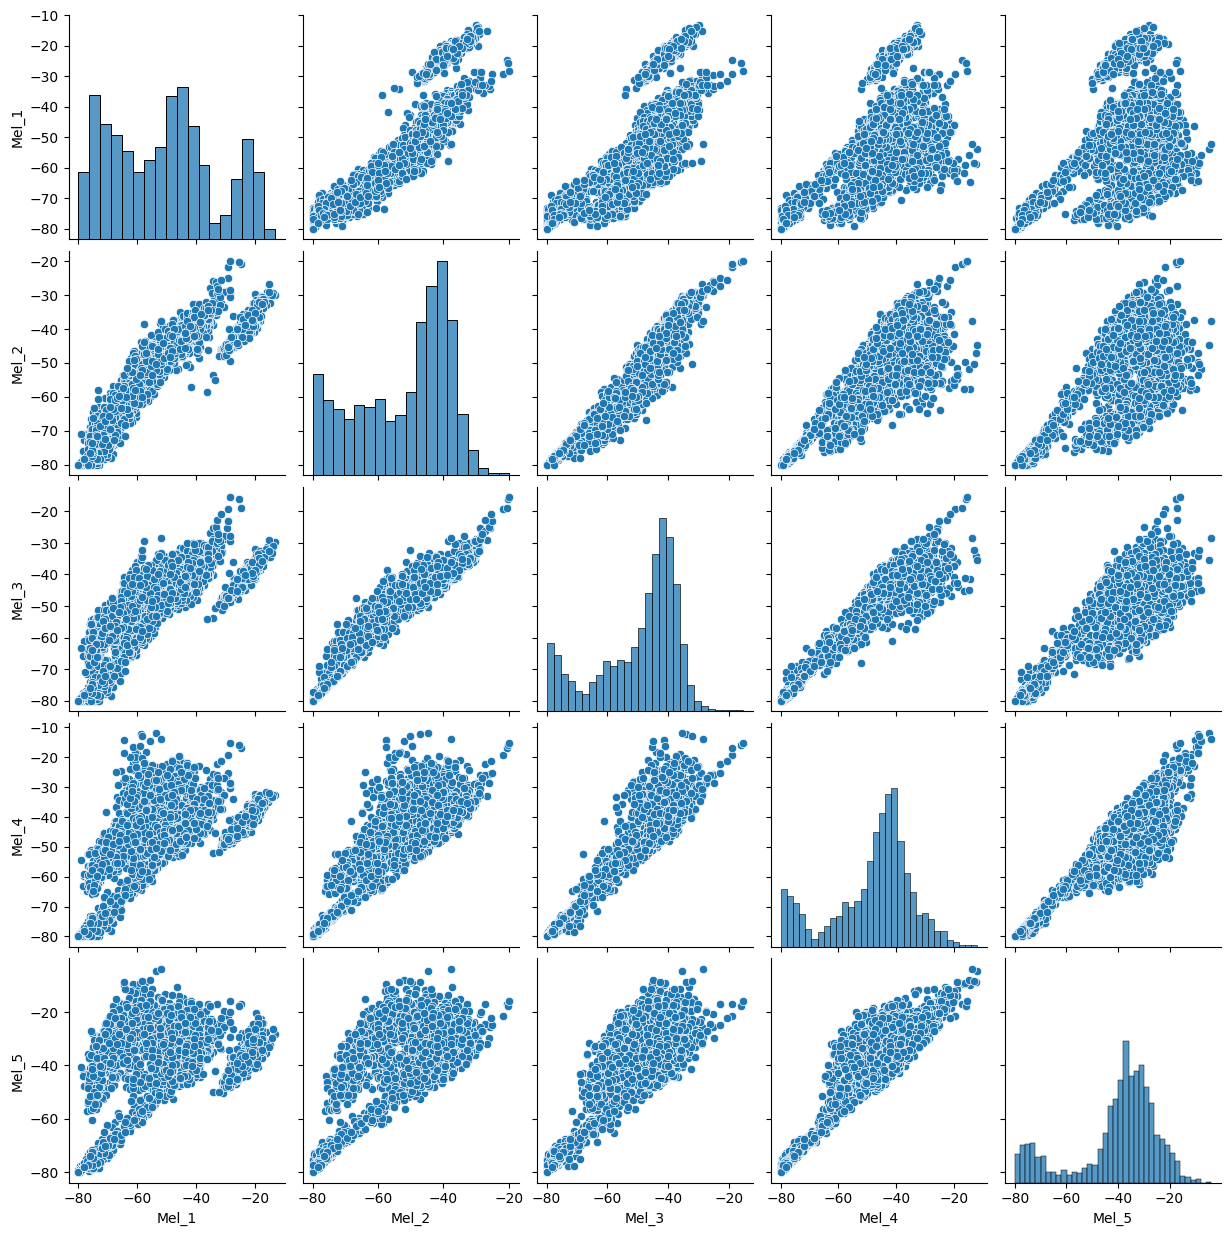

In [11]:
# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(features_df.iloc[:, 1], features_df.iloc[:, 2], alpha=0.5)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot (Only using first 5 features)
df = features_df.iloc[:, :5]
sns.pairplot(df)
plt.show()

##Why is dimensionality reduction important?



High-dimensional data poses significant challenges, particularly in visualization and analysis. Dimensionality reduction is important  for handling complex datasets. It improves visualization by eliminating clutter and revealing underlying patterns obscured by high dimensionality. By extracting key features and removing redundancies, it enhances clustering performance and significantly reduces computational load, making analysis more efficient


**Challenges/errors from the above experiments**
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1886
  warnings.warn  , this indicates that the  n_fft parameter exceeded the input signal length for some audio files. This discrepancy could introduce distortions in the resulting spectral features




##Apply PCA and t-SNE for dimensionality reduction and Compare the visualizations generated by both techniques. Select 3 components and Visualize them in 3D

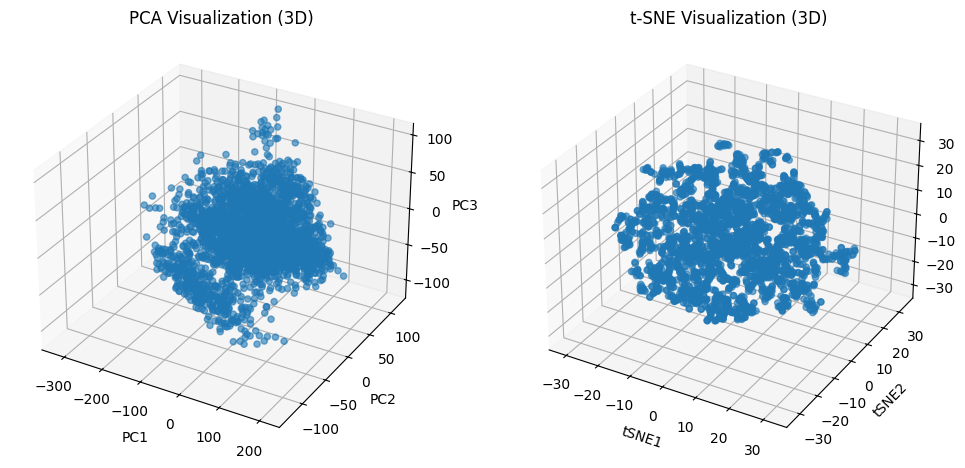

In [12]:

# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, perplexity=5, random_state=42)

# Convert features to a NumPy array
features_array = np.array(features)
features_tsne = tsne.fit_transform(features_array) # Pass the NumPy array to fit_transform
features_tsne = tsne.fit_transform(features_array)

# 3D Visualization goes here
# 3D Visualization for t-SNE
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], alpha=0.6)
ax1.set_title('PCA Visualization (3D)')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')

# 3D Visualization for t-SNE
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], alpha=0.6)
ax2.set_title('t-SNE Visualization (3D)')
ax2.set_xlabel('tSNE1')
ax2.set_ylabel('tSNE2')
ax2.set_zlabel('tSNE3')

plt.show()

## Which method (PCA or t-SNE) provides better separability of clusters and why?
Comparison of PCA and t-SNE for Cluster Separability

PCA Visualization

PCA reduces dimensionality by preserving the variance in the data.
 PCA is linear , preserves overall variance but struggles to clearly separate clusters in complex data.



t-SNE Visualization

t-SNE is a non-linear dimensionality reduction method, often better at preserving local structures.
The t-SNE plot shows more compact groups, suggesting better separation of clusters.
However, t-SNE can sometimes distort global relationships, making interpretation challenging.


Which Method Provides Better Separability?

t-SNE provides better separability because it captures local structures more effectively.
The PCA plot appears scattered, indicating that linear methods may not be sufficient for complex data distributions.

 t-SNE is the better choice for identifying structures. However, PCA remains useful for interpretability and understanding overall variance.

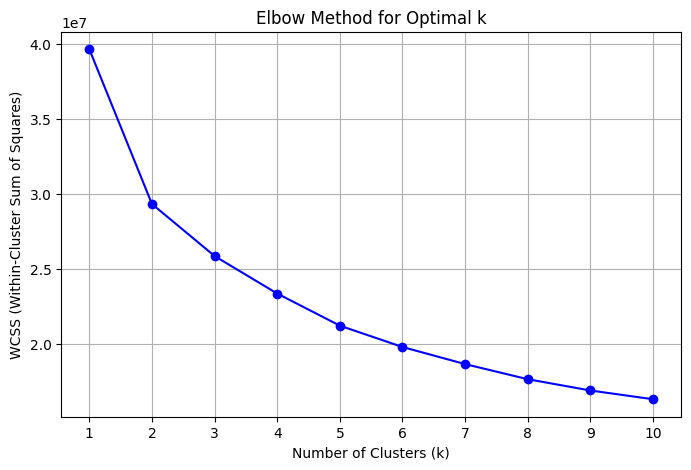

In [16]:

# Optimize number of clusters using Elbow Method
# Define a range of cluster values to test
wcss = []  # Within-cluster sum of squares
k_values = range(1, 11)  # Testing k from 1 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)  # Inertia: sum of squared distances to the closest cluster center

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_values)
plt.grid (True)
plt.show()

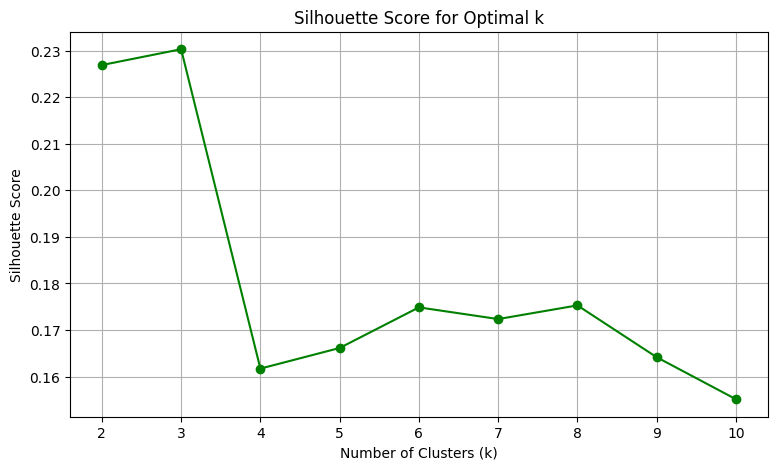

Optimal number of clusters (k) based on Silhouette Score: 3


In [18]:

# Optimize number of clusters using  Silhouette Score
silhouette_scores = []

for k in range(2, 11):  # Start from k=2 (since k=1 has no clusters to compare)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features)
    score = silhouette_score(features, labels)
    silhouette_scores.append(score)

# Plot the Silhouette Scores
plt.figure(figsize=(9, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='g')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

# Find the best k with highest silhouette score
optimal_k = range(2, 11)[np.argmax(silhouette_scores)]
print(f'Optimal number of clusters (k) based on Silhouette Score: {optimal_k}')

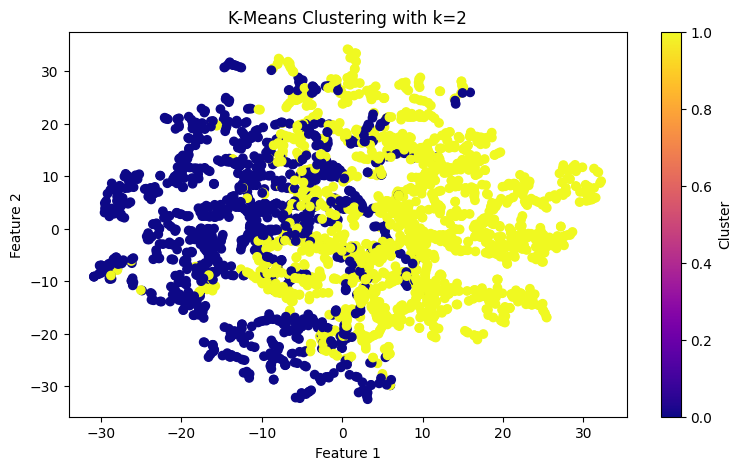

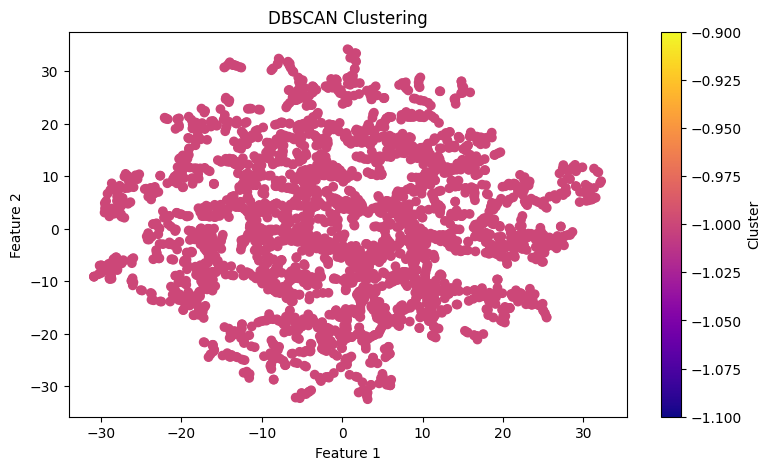

In [19]:
# Select optimal K based on elbow method (e.g., k=3)
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_array)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_array)

# Scatter Plot for K-Means Clusters
plt.figure(figsize=(9, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='plasma', marker='o')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(f'K-Means Clustering with k={optimal_k}')
plt.colorbar(label='Cluster')
plt.grid(False)
plt.show()

# Scatter Plot for DBSCAN Clusters
plt.figure(figsize=(9, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=dbscan_labels, cmap='plasma', marker='o')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('DBSCAN Clustering')
plt.colorbar(label='Cluster')
plt.grid(False)
plt.show()


In [20]:
# Evaluate clustering
kmeans_silhouette = silhouette_score(features, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")

K-Means - Silhouette Score: 0.2273, Davies-Bouldin Index: 1.6344
DBSCAN failed to form meaningful clusters.


## Discuss the result based on observation

In comparison to DBSCAN, K-Means showed improved clustering performance, achieving a Silhouette Score of 0.2269, which indicates a slight clustering structure, and a Davies-Bouldin Index of 1.6356, reflecting average cluster quality


K-Means is more suitable for this dataset due to its ability to handle spherical clusters, while DBSCAN struggles with varying densities and parameter sensitivity. Dimensionality reduction (e.g., t-SNE) improved clustering quality by projecting data into a lower-dimensional space, making clusters more separable and interpretable

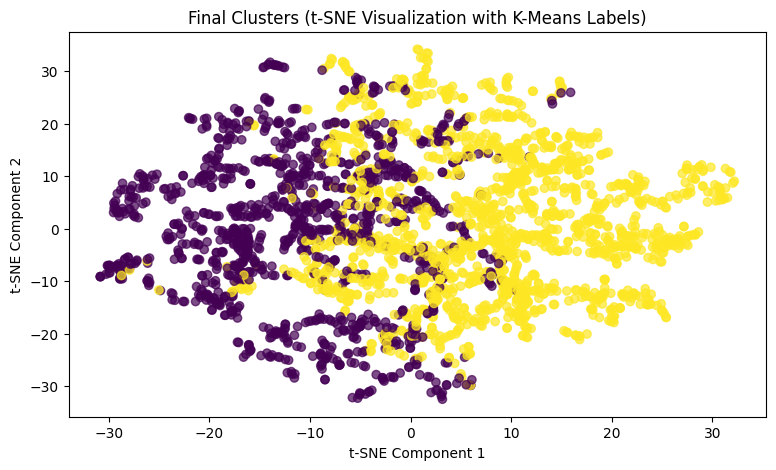

In [22]:


# Final visualization using t-SNE
plt.figure(figsize=(9, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()

## FINAL  ANALYSIS

**Why dimensionality reduction helped in clustering**:
Dimensionality Reduction helped in cluster seperability.In our high-dimensional dataset, features overlapped, obscuring distinct groups. Techniques like t-SNE, by capturing non-linear relationships and focusing on local structures, effectively reduced noise and revealed clearer cluster boundaries. This simplification allowed clustering algorithms, such as K-Means, to more accurately assign data points to their respective group



PCA helped in reducing the dataset to its most variant features. This removed much of the noise that was present in the higher dimensional dataset. While PCA did not provide as clear cluster seperation as t-SNE, it did allow for a much quicker clustering process, that still provided reasonable results


**Justify why certain clustering methods worked better.**

Dimensionality Reduction:

t-SNE: Chosen for its ability to reveal complex, non-linear cluster structures and improve visual separability.

PCA: Chosen for its ability to maintain global variance and provide interpretability, and for its speed. It is also good for removing noise.

Clustering Methods:

K-Means: Perfomed well  because of its  efficiency and the ability to find centroid based clusters and it aligns with the dataset structure.


DBSCAN:  Struggled because data lacks  ability to find density based clusters and identify outliers.




**Relate findings to real-world clustering challenges.**

Data Complexity:

In real-world scenarios, datasets are often high-dimensional and contain complex, non-linear relationships. For example, customer segmentation in e-commerce involves numerous features, including purchase history, demographics, and browsing behavior. Dimensionality reduction and non-linear clustering methods are essential for handling this complexity and revealing meaningful customer segments






